# Benchmarking scripts for SageNet

## Intallation of the running environment

* Install the envrioment of sageNet based on the instructions: https://github.com/MarioniLab/sagenet

In [2]:
import os
import sagenet as sg
import scanpy as sc
import squidpy as sq
import anndata as ad
import random
random.seed(10)
from sagenet.utils import glasso
import numpy as np
from sklearn.neighbors import KDTree
import pandas as pd
from scipy.stats import spearmanr
from tqdm import tqdm
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.spatial.distance import jensenshannon
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import utils
import importlib
importlib.reload(utils)
logging.getLogger().setLevel(logging.INFO)


/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch-2.0.1-py3.9-linux-x86_64.egg/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utilized functions and variables

In [5]:
def queryCell(sg_obj, test_adata):
    
    sg_obj.map_query(test_adata, save_pred=True, save_ent=True, save_prob=True, save_dist=True)
    return test_adata

In [6]:
def preprocessQuery(query_adata,gene_list):
    
        
    '''
    
    reformat the query_adata by the gene_list
    
    '''
    gene_indices = [query_adata.var_names.get_loc(gene) for gene in gene_list]
    selected_adata = query_adata[:, gene_indices]

    
    # remove all zeros
    sum_per_cell = selected_adata.X.sum(axis=1)
    zero_cells = sum_per_cell == 0
    selected_adata = selected_adata[~zero_cells, :]
    if(issparse(selected_adata.X)):
        selected_adata.X = np.asarray(selected_adata.X.todense())

    
    return selected_adata
    

In [7]:
def grid_array(df, n = 2): # auxilary funciton for griding the ST datasets
    
    '''
    
    The function is obtained from SageNet Tutorial
    
    '''
    min_x = np.min(df['x'])
    max_x = np.max(df['x'])
    to_ret_x = np.ones(len(df))
    for i in range(1, n):
        qr = min_x + i*((max_x - min_x)/n)
        to_ret_x[np.where(df['x'].values > qr)] = i + 1
    min_y = np.min(df['y'])
    max_y = np.max(df['y'])
    to_ret_y = np.ones(len(df))
    for i in range(1, n):
        qr = min_y + i*((max_y - min_y)/n)
        to_ret_y[np.where(df['y'].values > qr)] = i + 1
    temp = to_ret_x * (to_ret_y**3)
    df['grid_' + str(n)] = temp
    return df

In [8]:
def grid_adata(adata, n=[2, 3, 4]): # function to grid the ST datasets
    '''
    
    The function is obtained from SageNet Tutorial
    
    '''
    df = adata.obs
    for i in n:
        tag = 'grid_' + str(i)
        df_temp = df.groupby('sample').apply(grid_array, n = i)
        temp = np.searchsorted(np.unique(df_temp[tag].values), df_temp[tag].values)
        sg.utils.save_adata(adata, attr='obs', key=tag, data=temp)

In [9]:
grid_code = {
  "0" : 'top - right',
  "1" : 'top - middle',
  "2" : 'top - left',
  "3" : 'middle - right',
  "4" : 'middle - middle',
  "5" : 'middle - left',
  "6" : 'bottom - right',
  "7" : 'bottom - middle',
  "8" : 'bottom - left'
}

## 1. Spatial reconstruction of mouse gastrulation cells using single-cell resolution ST reference

### 1.1 Load data

* Please modify the data path as neccessary 

In [7]:
DATA_ROOT = "../benchmarking_data"

embryo1_l1 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo1_l1.h5ad"))
embryo1_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo1_l2.h5ad"))
embryo2_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo2_l2.h5ad"))
embryo3_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo3_l2.h5ad"))

print(embryo1_l1.shape,embryo1_l2.shape,embryo2_l2.shape,embryo3_l2.shape)

(10150, 351) (7656, 351) (6524, 351) (9408, 351)


### 1.2 Training the model with embryo1 L1

In [8]:
adata_r = embryo1_l1
device = "cpu"

glasso(adata_r, [0.5, 0.75, 1])
adata_r.obsm['spatial'] = np.array(adata_r.obs[['x','y']])

sq.gr.spatial_neighbors(adata_r, coord_type="generic")
sc.tl.leiden(adata_r, resolution=.01, random_state=0, key_added='leiden_0.01', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=.05, random_state=0, key_added='leiden_0.05', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=.1, random_state=0, key_added='leiden_0.1', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=.5, random_state=0, key_added='leiden_0.5', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=1, random_state=0, key_added='leiden_1', adjacency=adata_r.obsp["spatial_connectivities"])

In [9]:
sg_obj = sg.sage.sage(device=device)
sg_obj.add_ref(adata_r, comm_columns=['leiden_0.01', 'leiden_0.05', 'leiden_0.1', 'leiden_0.5', 'leiden_1'], tag='seqFISH_ref', epochs=20, verbose = False)

/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### 1.3 Evaluation on the embryo1 L2, embryo2 L2, embryo3 L3

In [10]:
test_adata_list = {"embryo1_l2":embryo1_l2,"embryo2_l2":embryo2_l2,"embryo3_l2":embryo3_l2}

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}

res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

for test_name in test_adata_list:
    cur_test_adata = test_adata_list[test_name]
    
    logging.info("querying cell for "+test_name)
    queried_test_adata = queryCell(sg_obj, cur_test_adata)
    logging.info("query DONE")

    cur_truth_coor = np.column_stack((queried_test_adata.obs['x'].values,queried_test_adata.obs['y'].values))
    truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
    truth_sorted_ind = np.argsort(truth_distances)
    
    precited_dist_mat = queried_test_adata.obsm['dist_map']
    predicted_sorted_ind = np.argsort(precited_dist_mat)    
    
    cur_truth_cell_types = queried_test_adata.obs['cell_type'].values
    
    # the nearest neighbor hit
    logging.info("evaluate avergae neighbor hit number")
    cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
    neighbor_hit_res['Dataset'].extend([test_name]*10)
    neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
    neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
    
    # Jessen-Shannon Distance
    logging.info("evaluate average Jessen-Shannon Distance")
    cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)

    # Spearman's rank correlation coefficient
    logging.info("evaluate average spearman's rank correlation coefficient")
    spearman_corr_list,spearman_p_list = utils.calSpearmanRank(precited_dist_mat,truth_distances)
    
    
    JSD_spearman_res['Dataset'].append(test_name)
    JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
    JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
    res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
    res_summary_all['Cell type'].extend(cur_truth_cell_types)
    res_summary_all['Average JSD'].extend(cur_jsd_list)
    res_summary_all['Average spearman'].extend(spearman_corr_list)
    

neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:querying cell for embryo1_l2
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' inste

In [11]:
res_summary_all.to_csv("results/sageNet_mouse_seqfish_ref.csv")

### 1.4 Benchmarking results

#### 1.4.1 Nearest neighbor hit

<Axes: xlabel='K nearest neighbor', ylabel='Average hit number'>

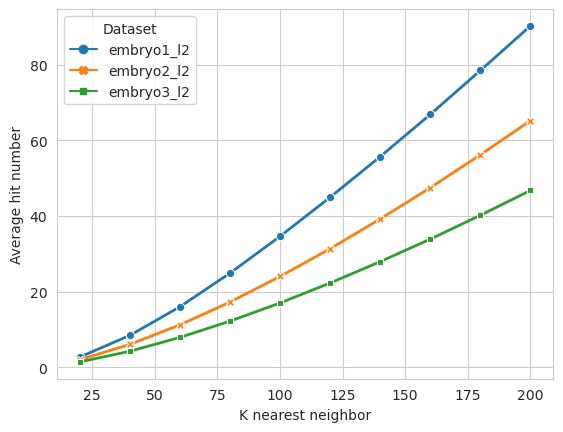

In [12]:
sns.set_style('whitegrid')
sns.lineplot(neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 1.4.2 Average JSD and  spearman's rank correlation coefficient

In [13]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,embryo1_l2,0.291898,0.542873
1,embryo2_l2,0.273375,0.520292
2,embryo3_l2,0.391394,0.378676


## 2. Spatial location inference across platforms: mouse gastrulation datasets

### 2.1 Load data

In [14]:
DATA_ROOT = "../benchmarking_data"
stereoseq_E2S1 = sc.read_h5ad(os.path.join(DATA_ROOT,"stereoseq_E2S1.h5ad"))
embryo1_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo1_l2.h5ad"))
embryo2_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo2_l2.h5ad"))
embryo3_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo3_l2.h5ad"))

### 2.2  Data preprocessing

* Partition of the training data

In [15]:
adata_r = stereoseq_E2S1
adata_r.obs['x'] = adata_r.obsm['spatial'][:,0]
adata_r.obs['y'] = adata_r.obsm['spatial'][:,1]
adata_r.obs['sample'] = ['E9.5_E2S1.MOSTA']*adata_r.obs.shape[0]
grid_adata(adata_r, [2, 3, 4])
adata_r.obs['position_3'] = [grid_code[k] for k in list(map(str, list(map(int, adata_r.obs['grid_3'].tolist()))))]
adata_r.obs['class_'] = 0

* Processing the testing data to obtain the genes that are in training data

In [16]:
test_adata_list = {"embryo1_l2":embryo1_l2,"embryo2_l2":embryo2_l2,"embryo3_l2":embryo3_l2}

for cur_test_name in test_adata_list:
    cur_test_data = test_adata_list[cur_test_name]
    cur_processed_data = preprocessQuery(cur_test_data,adata_r.var_names)
    test_adata_list[cur_test_name] = cur_processed_data

### 2.3 Training with Stereo-Seq E2S1 data

In [17]:
sg.utils.glasso(adata_r, [0.5, 0.75])
sg_stereo_obj = sg.sage.sage(device=device)
sg_stereo_obj.add_ref(adata_r, comm_columns=['grid_2', 'grid_3', 'grid_4'], tag='ST_all', epochs=20, verbose = False) 

/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:268: RuntimeWarning: divide by zero encountered in double_scalars
  precision_[idx, idx] = 1.0 / (
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:273: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  wa

### 2.4 Evaluation with single-cell resolution SeqFISH data

In [18]:

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}

res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

for test_name in test_adata_list:
    cur_test_adata = test_adata_list[test_name]
    
    logging.info("querying cell for "+test_name)
    queried_test_adata = queryCell(sg_stereo_obj, cur_test_adata)
    logging.info("query DONE")

    cur_truth_coor = np.column_stack((queried_test_adata.obs['x'].values,queried_test_adata.obs['y'].values))
    truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
    truth_sorted_ind = np.argsort(truth_distances)
    
    precited_dist_mat = queried_test_adata.obsm['dist_map']
    predicted_sorted_ind = np.argsort(precited_dist_mat)    
    
    cur_truth_cell_types = queried_test_adata.obs['cell_type'].values
    
    # the nearest neighbor hit
    logging.info("evaluate avergae neighbor hit number")
    cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
    neighbor_hit_res['Dataset'].extend([test_name]*10)
    neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
    neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
    
    # Jessen-Shannon Distance
    logging.info("evaluate average Jessen-Shannon Distance")
    cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)

    # Spearman's rank correlation coefficient
    logging.info("evaluate average spearman's rank correlation coefficient")
    spearman_corr_list,spearman_p_list = utils.calSpearmanRank(precited_dist_mat,truth_distances)
    
    
    JSD_spearman_res['Dataset'].append(test_name)
    JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
    JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
    res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
    res_summary_all['Cell type'].extend(cur_truth_cell_types)
    res_summary_all['Average JSD'].extend(cur_jsd_list)
    res_summary_all['Average spearman'].extend(spearman_corr_list)
    

neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:querying cell for embryo1_l2
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/sagenet-0.1.2-py3.9.egg/sagenet/sage.py:131: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_q.obs['class_'] = 0
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO:root:query DONE
INFO:root:evaluate avergae neighbor hit number
INFO:root:evaluate average Jessen-Shannon Distance
INFO:root:eval

In [19]:
res_summary_all.to_csv("results/sageNet_mouse_stereoseq_ref.csv")

### 2.5 Benchmarking results

#### 2.5.1 Nearest neighbor hit

<Axes: xlabel='K nearest neighbor', ylabel='Average hit number'>

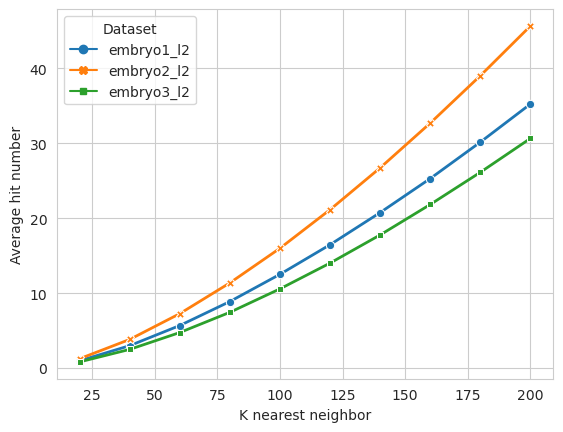

In [20]:
sns.set_style('whitegrid')
sns.lineplot(neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)


#### 2.5.2 Average JSD and spearman's rank correlation coefficient

In [21]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,embryo1_l2,0.377724,0.268742
1,embryo2_l2,0.297214,0.480516
2,embryo3_l2,0.422090,0.239372


## 3. Spatial location inference across platforms: human breast cancer datasets

### 3.1 Load data

In [22]:
DATA_ROOT = "../benchmarking_data"
human_breast_s06 = sc.read_h5ad(os.path.join(DATA_ROOT,"s06_normal_hvg1024.h5ad"))
human_breast_s08 = sc.read_h5ad(os.path.join(DATA_ROOT,"s08_normal_hvg1024.h5ad"))
human_breast_s08.X = human_breast_s08.X.todense()

### 3.2 Data preprocessing

In [23]:
adata_r = human_breast_s06
adata_r.obs['x'] = adata_r.obsm['spatial'][:,0]
adata_r.obs['y'] = adata_r.obsm['spatial'][:,1]
adata_r.obs['sample'] = ['E9.5_E2S1.MOSTA']*adata_r.obs.shape[0]
grid_adata(adata_r, [2, 3, 4])
adata_r.obs['position_3'] = [grid_code[k] for k in list(map(str, list(map(int, adata_r.obs['grid_3'].tolist()))))]
adata_r.obs['class_'] = 0

### 3.3 Training with 10X Visium human breast data

In [24]:
sg.utils.glasso(adata_r, [0.5, 0.75])
sg_breast_obj = sg.sage.sage(device=device)
sg_breast_obj.add_ref(adata_r, comm_columns=['grid_2', 'grid_3', 'grid_4'], tag='ST_all', epochs=20, verbose = False) 

/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:268: RuntimeWarning: divide by zero encountered in double_scalars
  precision_[idx, idx] = 1.0 / (
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:273: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  wa

### 3.4 Evaluation

In [25]:
cur_test_adata = human_breast_s08

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}

logging.info("querying cell for human breast data S08")
queried_test_adata = queryCell(sg_breast_obj, cur_test_adata)
logging.info("query DONE")

cur_truth_coor = np.column_stack((queried_test_adata.obs['x'].values,queried_test_adata.obs['y'].values))
truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
truth_sorted_ind = np.argsort(truth_distances)

precited_dist_mat = queried_test_adata.obsm['dist_map']
predicted_sorted_ind = np.argsort(precited_dist_mat)    
    
cur_truth_cell_types = queried_test_adata.obs['cell_type'].values
    
# the nearest neighbor hit
logging.info("evaluate avergae neighbor hit number")
cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
neighbor_hit_res['Dataset'].extend(["10X visium S08"]*10)
neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

# Jessen-Shannon Distance
logging.info("evaluate average Jessen-Shannon Distance")
cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)

# Spearman's rank correlation coefficient
logging.info("evaluate average spearman's rank correlation coefficient")
spearman_corr_list,spearman_p_list = utils.calSpearmanRank(precited_dist_mat,truth_distances)

    
JSD_spearman_res['Dataset'].append("10X visium S08")
JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))

res_summary_all['Dataset'].extend(["10X visium S08"]*len(cur_truth_cell_types))
res_summary_all['Cell type'].extend(cur_truth_cell_types)
res_summary_all['Average JSD'].extend(cur_jsd_list)
res_summary_all['Average spearman'].extend(spearman_corr_list)

neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)


INFO:root:querying cell for human breast data S08
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO:root:query DONE
INFO:root:evaluate avergae neighbor hit number
INFO:root:evaluate average Jessen-Shannon Distance
INFO:root:evaluate average spearman's rank correlation coefficient
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2801/2801 [00:03<00:00, 733.19it/s]


In [26]:
res_summary_all.to_csv("results/sageNet_human_breast.csv")

#### 3.4.1 Nearest neighbor hit

Text(0.5, 1.0, 'Evaluation of cell neighbor reconstrution for SageNet')

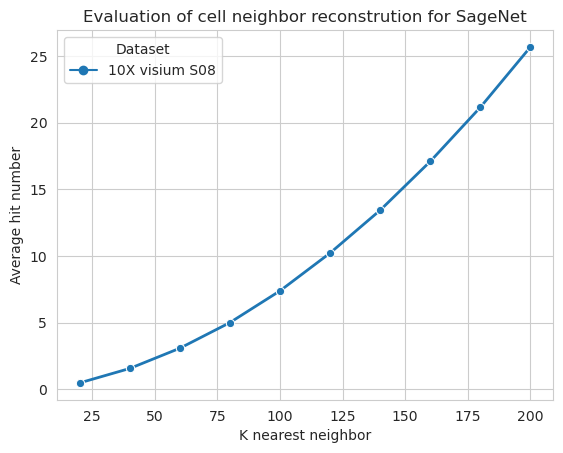

In [27]:
sns.set_style('whitegrid')
sns.lineplot(neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)
plt.title("Evaluation of cell neighbor reconstrution for SageNet")

#### 3.4.2 Average JSD and spearman's rank correlation coefficient

In [28]:
JSD_spearman_res

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,10X visium S08,0.386123,0.121653


## 4. Spatial location inference: mouse brain cells generated by MERSCOPE

### 4.1. Load data

In [57]:
DATA_ROOT = "../benchmarking_data"
left_brain_adata = sc.read_h5ad(os.path.join(DATA_ROOT,"s1r1_left_original.h5ad"))
right_brain_adata = sc.read_h5ad(os.path.join(DATA_ROOT,"s1r1_right_original.h5ad"))

### 4.2 Data preprocessing

In [58]:
adata_r = left_brain_adata
device = "cpu"

glasso(adata_r, [0.5, 0.75, 1])
adata_r.obsm['spatial'] = np.array(adata_r.obs[['x','y']])

sq.gr.spatial_neighbors(adata_r, coord_type="generic")
sc.tl.leiden(adata_r, resolution=.01, random_state=0, key_added='leiden_0.01', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=.05, random_state=0, key_added='leiden_0.05', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=.1, random_state=0, key_added='leiden_0.1', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=.5, random_state=0, key_added='leiden_0.5', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=1, random_state=0, key_added='leiden_1', adjacency=adata_r.obsp["spatial_connectivities"])

### 4.3 Training with left brain

In [59]:
sg_obj = sg.sage.sage(device=device)
sg_obj.add_ref(adata_r, comm_columns=['leiden_0.01', 'leiden_0.05', 'leiden_0.1', 'leiden_0.5', 'leiden_1'], tag='merfish_ref', epochs=20, verbose = False)

/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### 4.4 Evaluation

In [60]:
cur_test_adata = right_brain_adata

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}

logging.info("querying cell for merfish sample")
queried_test_adata = queryCell(sg_obj, cur_test_adata)
logging.info("query DONE")

cur_truth_coor = np.column_stack((queried_test_adata.obs['x'].values,queried_test_adata.obs['y'].values))
truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
truth_sorted_ind = np.argsort(truth_distances)

precited_dist_mat = queried_test_adata.obsm['dist_map']
predicted_sorted_ind = np.argsort(precited_dist_mat)    
    
cur_truth_cell_types = queried_test_adata.obs['cell_type'].values
    
# the nearest neighbor hit
logging.info("evaluate avergae neighbor hit number")
cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
neighbor_hit_res['Dataset'].extend(["merfish"]*10)
neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

# Jessen-Shannon Distance
logging.info("evaluate average Jessen-Shannon Distance")
cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)

# Spearman's rank correlation coefficient
logging.info("evaluate average spearman's rank correlation coefficient")
spearman_corr_list,spearman_p_list = utils.calSpearmanRank(precited_dist_mat,truth_distances)

    
JSD_spearman_res['Dataset'].append("merfish")
JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))

res_summary_all['Dataset'].extend(["merfish"]*len(cur_truth_cell_types))
res_summary_all['Cell type'].extend(cur_truth_cell_types)
res_summary_all['Average JSD'].extend(cur_jsd_list)
res_summary_all['Average spearman'].extend(spearman_corr_list)

neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)


INFO:root:querying cell for merfish sample
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/smli/miniconda2/envs/sageNet/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' i

#### 4.4.1 Nearest neighbor hit

Text(0.5, 1.0, 'Evaluation of cell neighbor reconstrution for SageNet')

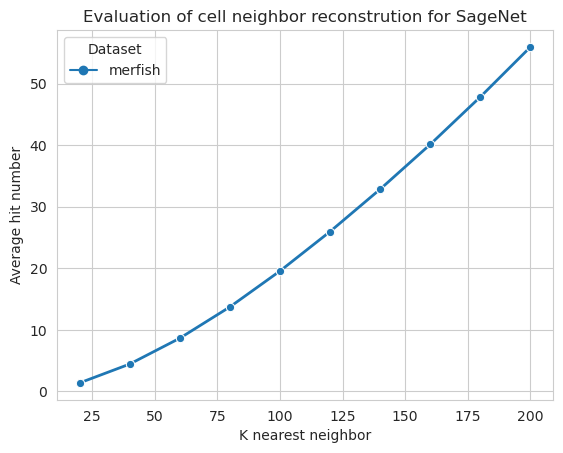

In [62]:
sns.set_style('whitegrid')
sns.lineplot(neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)
plt.title("Evaluation of cell neighbor reconstrution for SageNet")

#### 4.4.2 Spearman's rank correlation coefficient


In [63]:
# there is no JSD because this dataset do not contain information of cell types
JSD_spearman_res

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,merfish,NaN,0.492332
